William Savran <br>
10/26/2018

# On the Power of the N-Test


The N-test evaluates how well an earthquake forecast matches the observed number of events in a catalog [Zechar et al., 2010]. Here, we have modified the N-test as described by Zechar et al. [2010] to accomodate forecasts that produce stochastic event sets. Conceptually, the tests are identical, but in practice, this modification means we have removed the Poisson assumption required for CSEP1 evaluations by replacing the Poisson test distribution from Zechar et al. [2010] with an empirical distribution estimated from a stochastic event set. See Zechar et al. [2010] for an in-depth explanation of the N-test defined in CSEP1.


In CSEP2, we define an earthquake forecast through a stochastic event set, which is defined as the collection of $N$ synthetic catalogs produced by a single model. Each catalog in the stochastic event set should have identical model configurations, so that the catalogs represent individual realizations from the stochastic event set. At minimum the synthetic catalogs should contain the date-time, magnitude, and $(x,y)$ hypocenter locations for each forecasted event.

The power of a statistical evaluation is defined as the ability to correctly reject an incorrect null hypothesis. The N-test defined for stochastic event sets answers the following questions: (1) Given the empirical distribution of event counts, what is the probability of observing at most $N_{obs}$ earthquakes, and (2) given the empirical distribution of event counts, what is the probability of observing more than $N_{obs}$ events. Here, $N_{obs}$ is the number of events in the observed catalog. 

An important trait for a useful evaluation of an earthquake forecast is the ability to distinguish between similar models, such as UCERF3-ETAS versus UCERF3-NoFaults. An evaluation should be able to correctly distinguish an incorrect hypothesis with high likelihood. In the following sections, we will simulate the power of the N-test using these two aforementioned forecasts. In developing new tests for CSEP2, we should look to optimize the power of the tests employed, so that experimental questions can be answered with confidence.

The power of a statistical test is the probability of properly rejecting an incorrect null hypothesis. As shown by Zechar et al. [2010], we can simulate the power of a statistical test using the following approach (with slight modifications for stocahstic event sets): (1) given two forecasts (in this case UCERF3-ETAS and UCERF3-NoFaults), we will assume that one event-count forecast $\Lambda_1$ represents the 'true' generator of seismicity and $\Lambda_2$ represents the forecasted seismicity. Since both forecasts are stochastic event sets, we can sample $\Lambda_1$ and perform the N-test against $\Lambda_2$ for each catalog sampled from $\Lambda_1$.

This will generate two data products: (1) the quantile score $\gamma$ which can be used as a basis for rejection based on the significance level $\alpha$ and (2) the distribution of p-values produced from the evaluations. We can say the power of the test is related to (1) which is the fraction of test results that properly reject the null hypothesis at some significance level $\alpha$. 

# On the Power of the N-test
In the preliminary versions of this analysis, we assume that $\alpha=0.05$ and UCERF3-ETAS represents the 'true' event-count forecast. We will filter out events with $M_w < 3.95$ to provide some computational performance. We show the implementation of the procedure below.

##### **Note:** The cells need to be executed in order, because some variables are overwritten by later cells.

### Define Necessary Variables

In [1]:
# imports go here
import os
import time
import csep
import csep.utils.plotting
from csep.core.evaluations import number_test

%pylab inline

# Minimum Magnitude for Catalogs
mw_min = 0.0

# Significance for rejection 
alpha = 0.05

# two-sided test
tol = alpha / 2.0

# Filenames of target simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

Populating the interactive namespace from numpy and matplotlib


### Load Catalogs


In [2]:
# NOTE: this approach loads all catalogs into memory. needs about 12Gb to work.
# load ucerf3-etas stochastic event set
u3catalogs_filt = []
t0 = time.time()
u3catalogs = csep.load_stochastic_event_set(filename=filename, type='ucerf3', format='native', name='UCERF3-ETAS')
for u3catalog in u3catalogs:
    u3catalogs_filt.append(u3catalog.filter('magnitude > {}'.format(mw_min)))
t1 = time.time()
print('Loaded {} UCERF3 catalogs in {} seconds.\n'.format(len(u3catalogs_filt), (t1-t0)))

Loaded 10000 UCERF3 catalogs in 44.11890196800232 seconds.



In [3]:
u3nofaults_filt = []
t0 = time.time()
u3nofaults = csep.load_stochastic_event_set(filename=filename_nofaults, type='ucerf3', format='native', name='UCERF3-ETAS')
for u3nofault in u3nofaults:
    u3nofaults_filt.append(u3nofault.filter('magnitude > {}'.format(mw_min)))
t1 = time.time()
print('Loaded {} UCERF3 catalogs in {} seconds.\n'.format(len(u3nofaults_filt), (t1-t0)))

Loaded 10000 UCERF3 catalogs in 44.269054889678955 seconds.



### Compute N-test and Build Distributions

Recall, we are assuming that model $\Lambda_1$ repesents the 'true' distribution of simulated seismiscity. This means  we are going to treat the *i*-th synthetic catalog, $\Lambda_1^i$ from $\Lambda_1$ as if it were data. We are going to estimate a p-value from the N-test for all catalogs in $\Lambda_2$.

We are going to perform the N-test at the 95% confidence limit. For all of the following tests, $\alpha=0.05$.

#### $\Lambda_1$ = UCERF3-ETAS; $\Lambda_2$ = UCERF3-NoFaults

In [4]:
n_sim = 10000
n_cats = len(u3catalogs_filt)
p_values = []
results = []

for i in range(n_sim):
    true_catalog = u3catalogs_filt[i]
    
    # perform n-test
    p_value, ax = number_test(u3nofaults_filt, true_catalog, interp_kind='nearest', fill_value='extrapolate')
    p_values.append(p_value)
    
    # Rejected == 1 and Fail to reject == 0
    if p_value < tol or p_value > (1 - tol):
        results.append(1)
    else:
        results.append(0)
        

Rejected 224 catalogs out of 10000 resulting in a power of 0.02.


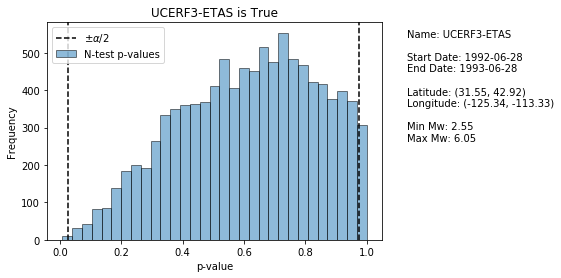

In [5]:
results = array(results)
ax = csep.utils.plotting.plot_histogram(p_values, tol, bins='fd', catalog=true_catalog, plot_args={'legend_loc': 'upper left',
                                                                             'xlabel': 'p-value',
                                                                             'sim_label': 'N-test p-values',
                                                                             'obs_label': r'$\pm \alpha/2$',
                                                                             'title': 'UCERF3-ETAS is True'})
# add second line to histogram
ax.axvline(x=(1-tol), color='black', linestyle='--')

# compute the number of rejected models
rejected = len(argwhere(results==1))
power = rejected / n_cats
print('Rejected {} catalogs out of {} resulting in a power of {:.2f}.'
      .format(rejected, n_cats, power))

#### $\Lambda_1$ = UCERF3-NoFaults; $\Lambda_2$ = UCERF3-ETAS

In [6]:
n_sim = 10000
n_cats = len(u3catalogs_filt)
p_values = []
results = []

for i in range(n_sim):
    true_catalog = u3nofaults_filt[i]
    
    # perform n-test
    p_value, ax = number_test(u3catalogs_filt, true_catalog, interp_kind='nearest', fill_value='extrapolate')
    p_values.append(p_value)
    
    # Rejected == 1 and Fail to reject == 0
    if p_value < tol or p_value > (1 - tol):
        results.append(1)
    else:
        results.append(0)
        

Rejected 1944 catalogs out of 10000 resulting in a power of 0.19.


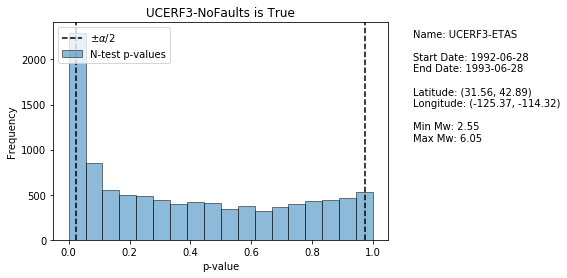

In [7]:
results = array(results)
ax = csep.utils.plotting.plot_histogram(p_values, tol, bins='fd', catalog=true_catalog, plot_args={'legend_loc': 'upper left',
                                                                             'xlabel': 'p-value',
                                                                             'sim_label': 'N-test p-values',
                                                                             'obs_label': r'$\pm \alpha/2$',
                                                                             'title': 'UCERF3-NoFaults is True'})
ax.axvline(x=(1-tol), color='black', linestyle='--')
rejected = len(argwhere(results==1))
power = rejected / n_cats
print('Rejected {} catalogs out of {} resulting in a power of {:.2f}.'
      .format(rejected, n_cats, power))

#### $\Lambda_1$ = UCERF3-ETAS; $\Lambda_2$ = UCERF3-NoFaults

In [10]:
from csep.core.evaluations import number_test
import csep.utils.plotting

n_sim = 10000
n_cats = len(u3catalogs_filt)
p_values = []
results = []

for i in range(n_sim):
    true_catalog = u3catalogs_filt[i]
    
    # perform n-test
    p_value, ax = number_test(u3catalogs_filt, true_catalog, interp_kind='nearest', fill_value='extrapolate')
    p_values.append(p_value)
    
    # Rejected == 1 and Fail to reject == 0
    if p_value < tol or p_value > (1 - tol):
        results.append(1)
    else:
        results.append(0)


Rejected 498 catalogs out of 10000.


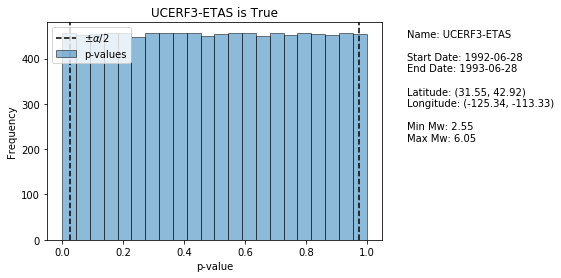

In [11]:
results = array(results)
ax = csep.utils.plotting.plot_histogram(p_values, tol, bins='fd', catalog=true_catalog, plot_args={'legend_loc': 'upper left',
                                                                             'xlabel': 'p-value',
                                                                             'sim_label': 'p-values',
                                                                             'obs_label': r'$\pm \alpha/2$',
                                                                             'title': 'UCERF3-ETAS is True'})
ax.axvline(x=(1-tol), color='black', linestyle='--')
rejected = len(argwhere(results==1))
power = rejected / n_cats
print('Rejected {} catalogs out of {}.'
      .format(rejected, n_cats, power))

# References
Zechar, J. D., Gerstenberger, M. C., & Rhoades, D. A. (2010). Likelihood-based tests for evaluating space–rate–magnitude earthquake forecasts. Bulletin of the Seismological Society of America, 100(3), 1184-1195.